#### Imports

In [0]:
%matplotlib inline
import networkx as nx
from networkx.algorithms.community.quality import performance, modularity
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
import urllib
import sys
import os
from google.colab import drive

#### Helper functions

In [0]:
# Get node positions using palslayout

file = urllib.request.urlretrieve('https://github.com/kalngyk/repoman/raw/master/palslayout.so', 'palslayout.so')
import palslayout

def getpos(G, communities):
    node2idx = dict([(x, i) for (i, x) in enumerate(G.nodes)])
    clusters = []
    for n, c in enumerate(communities):
        indices = [node2idx[x] for x in G.nodes if x in c]
        for i in indices:
            clusters.append([i, n])
    clusters = np.array(clusters)
    edges = np.array([[node2idx[x], node2idx[y]] for x, y in G.edges])
    pos = palslayout.getpos(edges, clusters)
    nodes = np.array(G.nodes)
    results = dict([(nodes[int(i)], np.array([j, k])) for i, j, k in pos])
    return results

#### Give access to Google Drive

In [3]:
savedir = ""
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    savedir = "/content/gdrive/My Drive/colab/"
    try:
        os.mkdir(savedir)
    except FileExistsError:
        print("Directory \"%s\" already exists" % (savedir))
root_path = "/content/gdrive/My Drive/CD-Project-shared/Project/"
sys.path.append(root_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Directory "/content/gdrive/My Drive/colab/" already exists


####Import self-made library

In [0]:
import readwrite
from girvan_newman import girvan_newman
from label_propagation import label_propagation
from markov_cluster import markov_cluster

tsv_path = root_path + "tsv/"
gml_path = root_path + "gml/"
pkl_path = root_path + "pkl/"
txt_path = root_path + "txt/"
png_path = root_path + "png/"

####Construct adjacency matrix and get statistics

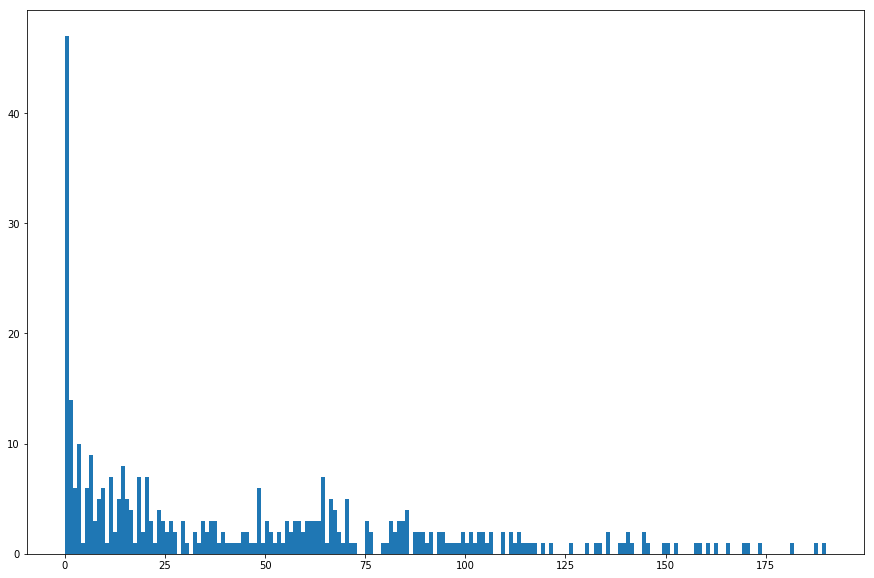

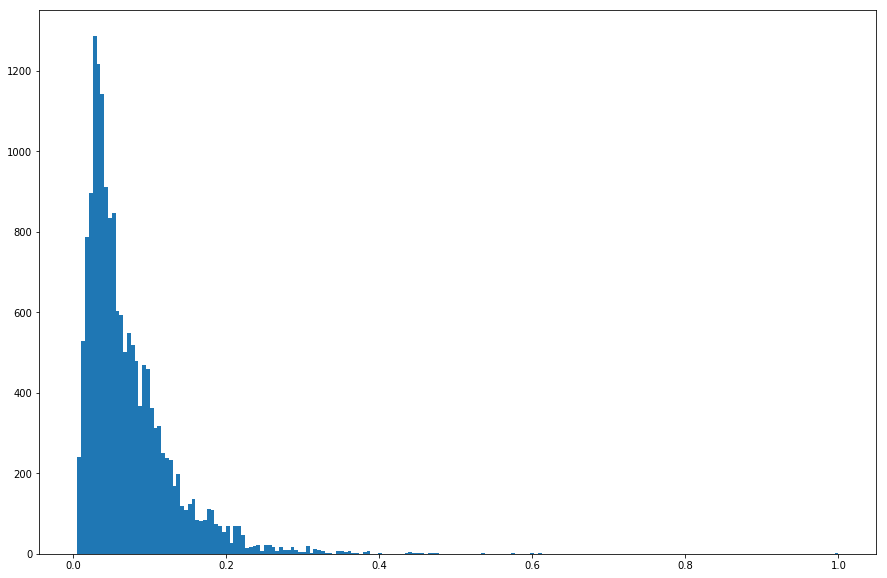

In [23]:
# construct adjacency matrix and label list
data = "vscode_repo_366_v1"
tsv_file_path = tsv_path + data + ".tsv"
adjmat, labels = readwrite.import_tsv_mat(tsv_file_path, directed=False)

# compute and plot degrees of every node
in_degree = np.count_nonzero(adjmat, axis=0)
out_degree = np.count_nonzero(adjmat, axis=1)
degree = (in_degree + out_degree) / 2
plt.figure(figsize=(15, 10))
_ = plt.hist(degree, bins=int(np.max(degree)))

# plot all the non-zero weights in a histogram
plt.figure(figsize=(15, 10))
_ = plt.hist(adjmat[adjmat != 0].reshape(-1), bins=200)

####Filter the adjacency matrix, build the graph, and detect communites

In [26]:
# prepare community detection algorithms
algorithms = ["GN", "LP", "MC"]
functions = [girvan_newman, label_propagation, markov_cluster]
filelist = []

# filter the adjacency matrix
d_threshold = 125
chosen_list = np.nonzero(degree < d_threshold)[0]
filtered_adjmat = adjmat[:, chosen_list][chosen_list, :]
filtered_labels = list(np.array(labels)[chosen_list])

w_threshold = 0.025
filtered_adjmat[filtered_adjmat < w_threshold] = 0

# build the graph
G = readwrite.mat2graph(filtered_adjmat, filtered_labels)

for algorithm, function in zip(algorithms, functions):
    # define file paths
    filename = data + "_" + str(d_threshold) + "_" + str(w_threshold) + "_" + algorithm
    gml_file_path = gml_path + filename + ".gml"
    txt_file_path = txt_path + filename + ".txt"
    pkl_file_path = pkl_path + filename + ".pkl"

    # community detection
    if function == girvan_newman:
        communities = function(G, 20, autothreshold=True)
    elif function == label_propagation:
        communities = function(G, iterNum=10)
    elif function == markov_cluster:
        communities = function(G, power=15, inflation=15, numIter=40, decimals=4)
    else:
        communities = []

    # report some key results to stdout
    print(algorithm+":", len(communities), modularity(G, communities))
    
    # Find nodes layout using pals
    pos = getpos(G, communities)

    readwrite.export_gml(G, communities, pos, gml_file_path)
    readwrite.export_pkl(G, communities, pkl_file_path)
    readwrite.export_txt(G, communities, data, algorithm, d_threshold, w_threshold, txt_file_path)
    filelist.append(filename)
    
print(filelist)

GN: 20 0.002146514080252179
[Done] export gml file: /content/gdrive/My Drive/CD-Project-shared/Project/gml/vscode_repo_366_v1_125_0.025_GN.gml
LP: 10 0.29455050607734634
[Done] export gml file: /content/gdrive/My Drive/CD-Project-shared/Project/gml/vscode_repo_366_v1_125_0.025_LP.gml
MC: 47 0.01216902120743021
[Done] export gml file: /content/gdrive/My Drive/CD-Project-shared/Project/gml/vscode_repo_366_v1_125_0.025_MC.gml
['vscode_repo_366_v1_125_0.025_GN', 'vscode_repo_366_v1_125_0.025_LP', 'vscode_repo_366_v1_125_0.025_MC']


In [7]:
import pickle
from random import random

for filename in filelist:
    print(filename)
    pklfilename = pkl_path + filename + ".pkl"
    with open(pklfilename, 'rb') as f:
        G, communities = pickle.load(f)
    
    # Find nodes layout using pals
    pos = getpos(G, communities)
    
    # Gives colors to the clusters
    color_map = []
    cls_elem_count = np.array([len(c) for c in communities])
    n2c = dict()
    for i, c in enumerate(communities):
        for n in c:
            n2c[str(n)] = i

    palette = []
    for i in range(len(cls_elem_count)):
        palette.append((random(), random(), random()))
    
    for node in G.nodes:
        c = n2c[node]
        idx = c % len(palette)
        color_map.append(palette[idx])

    png_file_path = png_path + filename + ".png"
    plt.figure(figsize=(17, 15))
    nx.draw(G, pos=pos, node_color=color_map, edge_color='grey', with_labels=True)
    plt.savefig(png_file_path)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.